In [4]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from scipy.cluster import hierarchy
from skimage import io
from collections import defaultdict
import numpy as np
import SPHC as sphc
import superpixels as sp
import plot as pl

In [6]:
imagePath = 'images/'
#['caneca1.jpg', 'caneca2.jpg', 'face1.jpg', 'face2.jpg', 'face3.jpg']
imageFiles = ['3063.jpg', '385039.jpg']

#SLIC Parameters:
numSegments = 500  # How many superpixels to start with - input for SLIC function

#SPHC Parameters:
segmentsToMerge =[400, 500]#  [70, 80, 90] #[100, 200, 300, 400, 480] #3 # How many superpixels to merge based on color similarity
distance_limit = 0.3 # Limits which segments get merged based on their difference in average color

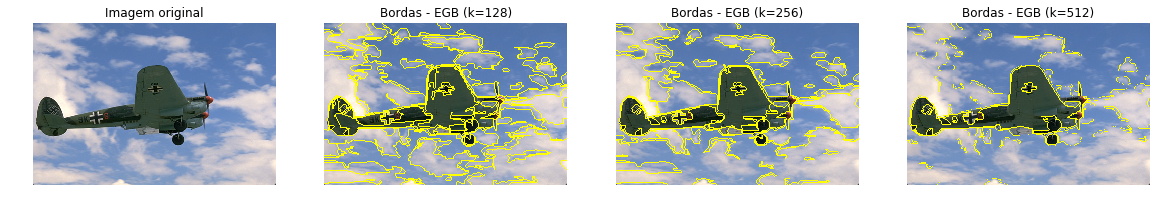

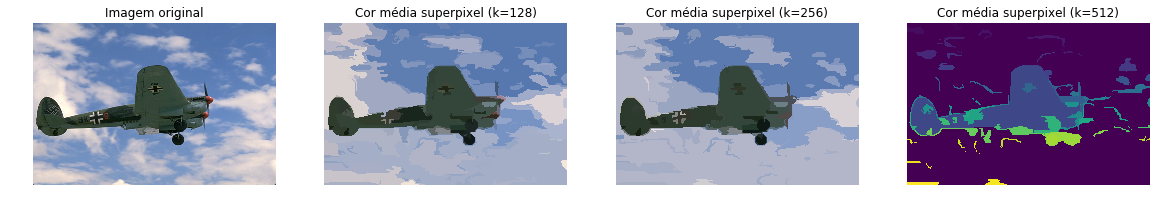

In [11]:
for file in imageFiles[0:1]:
    image = img_as_float(io.imread((imagePath + file)))
    
    #felz 500 segments
    seg_felz500 = felzenszwalb(image, scale = 128, min_size = 50)
    bound_felz500 = mark_boundaries(image, seg_felz500)
    felz500, _, _ = sp.color_superpixel(image, seg_felz500)
    
    #felz 250 segments
    seg_felz250 = felzenszwalb(image, scale = 256, min_size = 50)
    bound_felz250 = mark_boundaries(image, seg_felz250)
    felz250, _, _ = sp.color_superpixel(image, seg_felz250)
    
    #felz 50 segments
    seg_felz50 = felzenszwalb(image, scale = 512, min_size = 50)
    bound_felz50 = mark_boundaries(image, seg_felz50)
    felz50, _, _ = sp.color_superpixel(image, seg_felz250)
        
    #plot boundaries
    images = [image, bound_felz500, bound_felz250, bound_felz50]
    labels = ["Imagem original", "Bordas - EGB (k=128)", 
              "Bordas - EGB (k=256)", "Bordas - EGB (k=512)"]
    pl.plot_compare_4(images, labels, True)
    
    #plot images
    images = [image, felz500, felz250, seg_felz50]
    labels = ["Imagem original", "Cor média superpixel (k=128)", 
              "Cor média superpixel (k=256)", "Cor média superpixel (k=512)"]
    pl.plot_compare_4(images, labels, True)

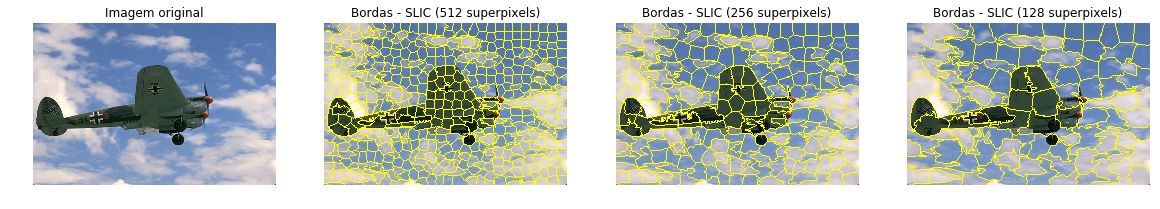

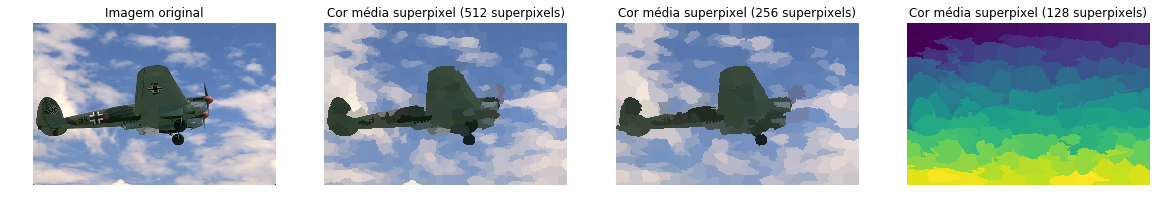

In [10]:
for file in imageFiles[0:1]:
    image = img_as_float(io.imread((imagePath + file)))
    
    #slic 500 segments
    seg_slic500 = slic(image, n_segments = 512, slic_zero = False)
    bound_slic500 = mark_boundaries(image, seg_slic500)
    slic500, _, _ = sp.color_superpixel(image, seg_slic500)
    
    #slic 250 segments
    seg_slic250 = slic(image, n_segments = 256, slic_zero = False)
    bound_slic250 = mark_boundaries(image, seg_slic250)
    slic250, _, _ = sp.color_superpixel(image, seg_slic250)
    
    #slic 50 segments
    seg_slic50 = slic(image, n_segments = 128, slic_zero = False)
    bound_slic50 = mark_boundaries(image, seg_slic50)
    slic50, _, _ = sp.color_superpixel(image, seg_slic250)
    
    #plot boundaries
    images = [image, bound_slic500, bound_slic250, bound_slic50]
    labels = ["Imagem original", "Bordas - SLIC (512 superpixels)", 
              "Bordas - SLIC (256 superpixels)", "Bordas - SLIC (128 superpixels)"]
    pl.plot_compare_4(images, labels, True)
    
    #plot images
    images = [image, slic500, slic250, seg_slic50]
    labels = ["Imagem original", "Cor média superpixel (512 superpixels)", 
              "Cor média superpixel (256 superpixels)", "Cor média superpixel (128 superpixels)"]
    pl.plot_compare_4(images, labels, True)

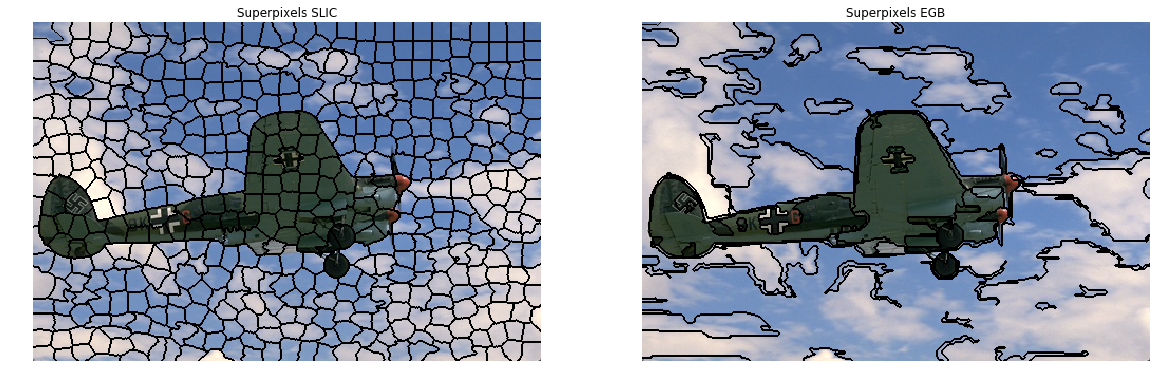

In [12]:
image = img_as_float(io.imread((imagePath + imageFiles[0])))
segs_slic = slic(image, n_segments = 500, slic_zero = True)
segs_felz = felzenszwalb(image, scale = 256, min_size = 50)

fig, (ax2, ax3) = plt.subplots(1,2, figsize=(20, 20))
#ax1.imshow(image)
#ax1.set_title("Imagem original")
#ax1.set_axis_off()
ax2.imshow(mark_boundaries(image, segs_slic, color=(0,0,0)))
ax2.set_title("Superpixels SLIC")
ax2.set_axis_off()
ax3.imshow(mark_boundaries(image, segs_felz, color=(0,0,0)))
ax3.set_title("Superpixels EGB")
ax3.set_axis_off()
plt.show() 

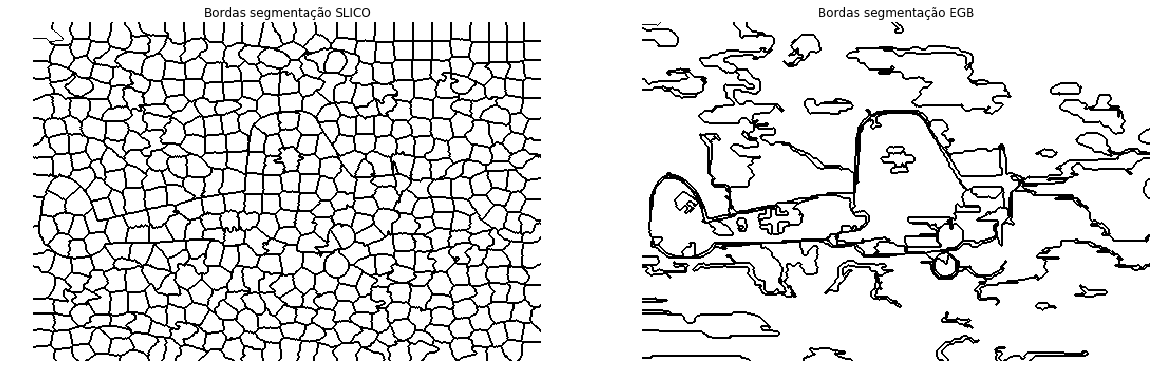

In [15]:
img = np.zeros(image.shape,dtype=np.uint8)
img.fill(255)

f, (ax2, ax3) = plt.subplots(1, 2, figsize=(20,20))
ax2.imshow(mark_boundaries(img, segs_slic, color=(0, 0, 0)))
ax2.set_title("Bordas segmentação SLICO")
ax3.imshow(mark_boundaries(img, segs_felz, color=(0, 0, 0)))
ax3.set_title("Bordas segmentação EGB")
ax2.set_axis_off()
ax3.set_axis_off()
plt.show() 

48 49


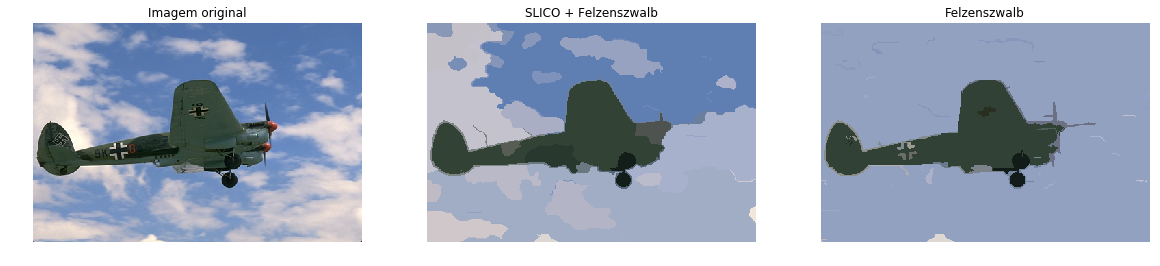

In [24]:
slic_image, _, _ = ut.color_superpixel(image, segs_slic)

segs_fs = felzenszwalb(slic_image, scale = 1536, min_size = 20)
segs_f = felzenszwalb(image, scale = 975, min_size = 20)
fs_image, n_segs_fs, colors_fs = ut.color_superpixel(slic_image, segs_fs)
f_image, n_segs_f, _ = ut.color_superpixel(image, segs_f)

print(n_segs_fs, n_segs_f)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
ax1.imshow(image)
ax1.set_title("Imagem original")
ax2.imshow(fs_image)
ax2.set_title("SLICO + Felzenszwalb")
ax3.imshow(f_image)
ax3.set_title("Felzenszwalb")
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
plt.show() 

In [25]:
Z = hierarchy.linkage(colors_fs)
print(Z.shape)
print(segs_fs.shape)

(47, 4)
(321, 481)


In [26]:
it = 4
step = int(n_segs_felz/it)
cutz_images = []
cutz_labels = []
bondz_images = []
bondz_labels = []

segments = segs_fs
n_seg = n_segs_fs

cutz_images.append(fs_image)
cutz_labels.append("Hierarquia - " + str(n_seg) + " partições")
bondz_images.append(mark_boundaries(img, segs_fs, color=(0, 0, 0)))
bondz_labels.append("Bordas - " + str(n_seg) + " partições")

for ix in range(it-1, 0, -1):
    cluster_size= int(ix * step)
 
    cutz = hierarchy.cut_tree(Z, n_clusters = cluster_size)
    cutz_segs = copy.deepcopy(segments)

    for i in range(len(segments)):
        for j in range(len(segments[i])):
            index = segments[i][j]
            cutz_segs[i][j] = cutz[index][0]

    felz_image, _, _ = ut.color_superpixel(slic_image, cutz_segs)        
    
    
    cutz_images.append(felz_image)
    cutz_labels.append("Hierarquia - " + str(cluster_size) + " partições")
    
    bondz_images.append(mark_boundaries(img, cutz_segs, color=(0, 0, 0)))
    bondz_labels.append("Bordas - " + str(cluster_size) + " partições")
    
ut.plot_compare_4(cutz_images, cutz_labels, True)
ut.plot_compare_4(bondz_images, bondz_labels, True)

##################

NameError: name 'n_segs_felz' is not defined

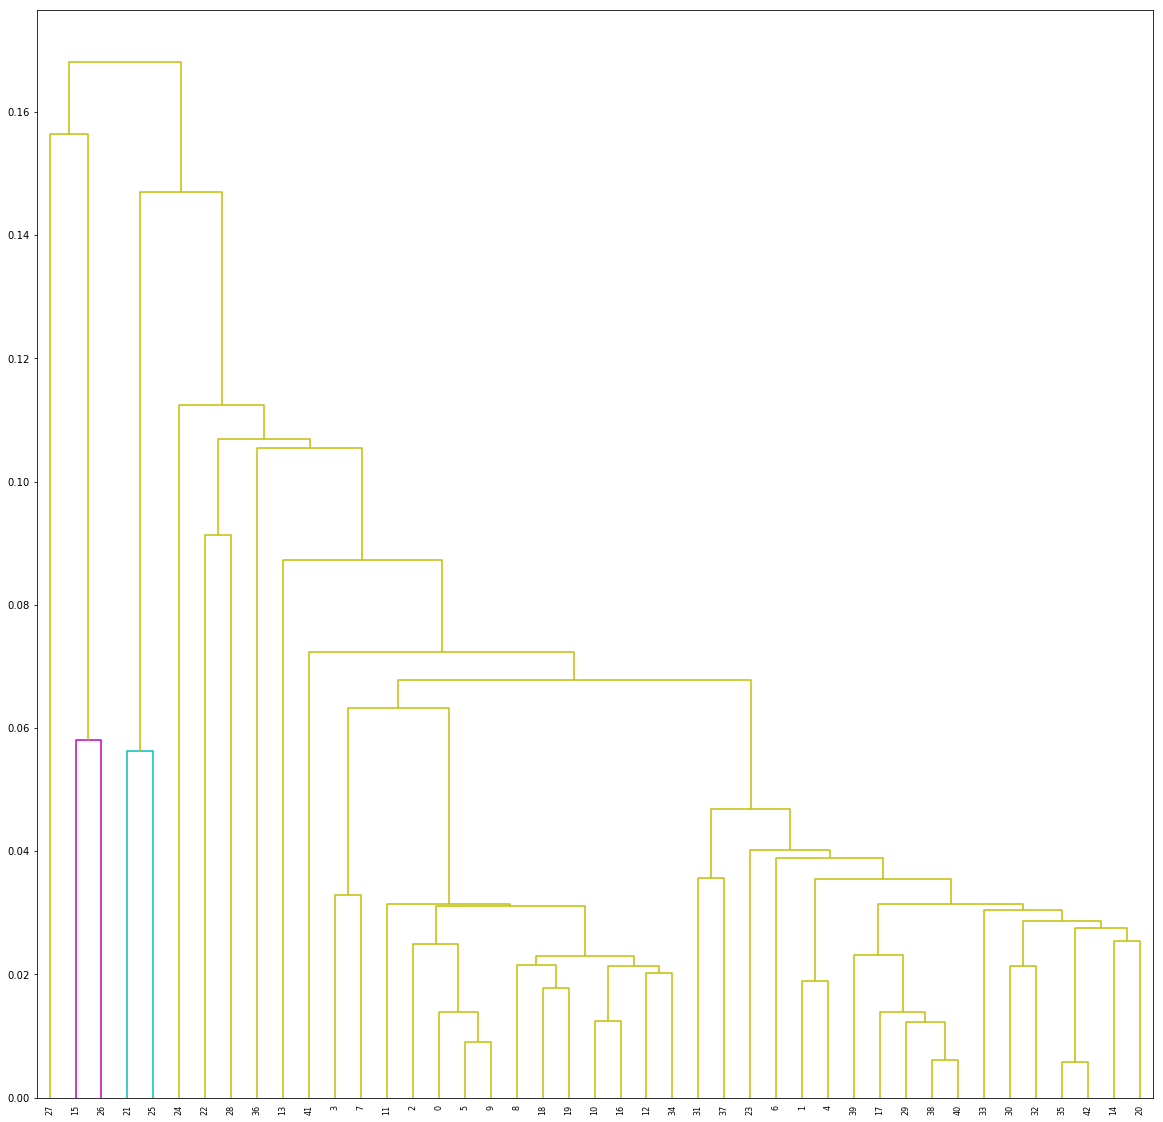

In [43]:
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig = plt.subplots(1, 1, figsize=(20,20))
dn1 = hierarchy.dendrogram(Z, above_threshold_color='y', count_sort='ascending', show_contracted = True)
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

## Old Merge segment method (SPHC)

In [ ]:
segm_size = 87
segm_grid = sphc.getSPHCsegments(segments, image, numToMerge = segm_size, max_dist = distance_limit)

In [ ]:
fig = plt.figure("Segments", figsize = (10,10))
ax = fig.add_subplot(1,1,1)
ax.imshow(mark_boundaries(image, segm_grid))
plt.axis("off")
plt.show()

In [ ]:
image = img_as_float(io.imread((imagePath + imageFiles[2])))
segs_slico = slic(image, slic_zero = True)
segs_felz = felzenszwalb(image, scale = 200, min_size = 30)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
ax1.imshow(image)
ax1.set_title("Imagem Original")
ax2.imshow(mark_boundaries(image, segs_slico))
ax2.set_title("Bordas segmentação SLICO")
ax3.imshow(mark_boundaries(image, segs_felz))
ax3.set_title("Bordas segmentação Felzenszwalb")
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
plt.show() 

In [ ]:
img = np.zeros([400,500,3],dtype=np.uint8)
img.fill(255)

f, (ax2, ax3) = plt.subplots(1, 2, figsize=(20,20))
ax2.imshow(mark_boundaries(img, segs_slico, color=(0, 0, 0)))
ax2.set_title("Bordas segmentação SLICO")
ax3.imshow(mark_boundaries(img, segs_felz, color=(0, 0, 0)))
ax3.set_title("Bordas segmentação Felzenszwalb")
ax2.set_axis_off()
ax3.set_axis_off()
plt.show() 